<a href="https://colab.research.google.com/github/ngoclesydney/Anomaly-Detection-with-Swat-Dataset/blob/master/Anomaly_3_attacks_25_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction using SWaT dataset
***Outline:***
> The SWaT dataset and how to clean the data

> Extract attacks (Multivariate time series) and present in matplotlib

> Design the model

> Train the model

> Test the model

> Evaluat and save the model




## Problem statement:
Prediction in time series is important to solve the anomaly attacks detection in Industrial Control System (ICS). 

In this presentation, we will show one of the algorithms to forecast the graph of the network trafic. We will CNN and RNN to train model to predict the data of three kind of attacks in SWaT dataset.

In [15]:
# optional; purely cosmetic/legacy
# from __future__ import annotations
import zipfile
import sys
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())  # sanity check: CPU/GPU visible?

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# tiny smoke test so we know TF actually runs
x = tf.constant([1.0, 2.0, 3.0])
print("x * 2 ->", (x * 2).numpy())


Python: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
TensorFlow: 2.20.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
x * 2 -> [2. 4. 6.]


In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Secure Water Treatment (SWaT) Dataset

The data collected from the testbed consists of 11 days of continuous operation. 7 days’ worth of data was collected under normal operation while 4 days’ worth of data was collected with attack scenarios.  During the data collection, all network traffic, sensor and actuator data were collected.

For more information about this dataset please see the link:
[SWaT website](https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/)

Attack is on LIT301 - the value is spoofed to 1024 to eventually lead to an underflow.

Attack is from 2019-07-20T07:13:27.0030059Z (row 9598) to 2019-07-20T07:17:47.0050048Z (row 9857)

Normal plant run time for training data is from 2019-07-20T04:33:27.004013Z
 (row 1) to 2019-07-20T06:48:27.004013Z (row 8097)

TRAIN_SPLIT = 8097

Past history we should aim to do 15 minutes (900 seconds): from 2019-07-20T06:48:28.0050048Z (row 8098) to 2019-07-20T07:03:28.004013Z (row 8998)

Future target (total number of predictions): from 2019-07-20T07:03:29.004013Z (row 8999) to 2019-07-20T08:33:27.004013Z
 (row 14397). Will have to complete this in batches.

In [35]:
import pandas as pd
import requests
import io

FILE_ID = "1vFxxDKXKz7gmcCLeM1E3hFANiBgfRwSp"
URL = f"https://drive.google.com/uc?export=download&id={FILE_ID}"

# download
r = requests.get(URL)
r.raise_for_status()

# sanity check: ensure it's not HTML pretending to be data
if b"<html" in r.content[:200].lower():
    raise RuntimeError("Google Drive sent an HTML page instead of the CSV. Check share permissions or use gdown.")

# load into dataframe directly
df = pd.read_csv(io.BytesIO(r.content))
print("DataFrame shape:", df.shape)
# if you've already loaded df:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, errors="coerce")
df = df.dropna(how="all", axis=1)              # remove columns that are entirely NaN
sensor_prefixes = ("LIT", "FIT", "AIT", "P", "MV", "S", "M")
sensor_cols = [c for c in df.columns if c.startswith(sensor_prefixes)]

# rows where at least ONE sensor has a value
rows_with_data = df[sensor_cols].notna().any(axis=1)

print("Total rows:", len(df), "rows with sensor data:", rows_with_data.sum())

# preview only the interesting part



DataFrame shape: (2205, 96)
Total rows: 2205 rows with sensor data: 2205


In [34]:
df.head()

,Timestamp,A#DAD,FIT101,LIT101,MV101,P102,P101,AIT202,AIT203,AIT201,...,P602,P603,PLC4,PLC1,PLC6,PLC5,PLC3,PLC2,P1SA1,Plant
0,2021-07-21 12:55:45,"CPS_ALID_P3_SD6#99#Check MV301, 302, 303",0.0,638.210600,1,1,0,6.349846,519.0464,15.028198,...,1,1,4,2,2,12,99,2,0.0,False
1,2021-07-21 12:55:46,NaN,0.0,637.818054,1,1,0,6.379326,519.0464,15.028198,...,1,1,4,2,2,12,99,2,0.0,False
2,2021-07-21 12:55:47,NaN,0.0,637.975100,1,1,0,6.390541,519.0464,15.028198,...,1,1,4,2,2,12,99,2,0.0,False
3,2021-07-21 12:55:48,NaN,0.0,638.053600,1,1,0,6.390541,519.0464,15.028198,...,1,1,4,2,2,12,99,2,0.0,False
4,2021-07-21 12:55:49,NaN,0.0,637.661100,1,1,0,6.404961,519.0464,15.028198,...,1,1,4,2,2,12,99,2,0.0,False


In [36]:
TRAIN_SPLIT = 8097
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [37]:
tf.random.set_seed(13)


In [38]:
def create_time_steps(length: int):
    return list(range(-length, 0))

C:\Users\DELL\AppData\Local\Temp\ipykernel_4308\2868975025.py:53: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  s = s.resample(freq).mean().interpolate(limit_direction="both")


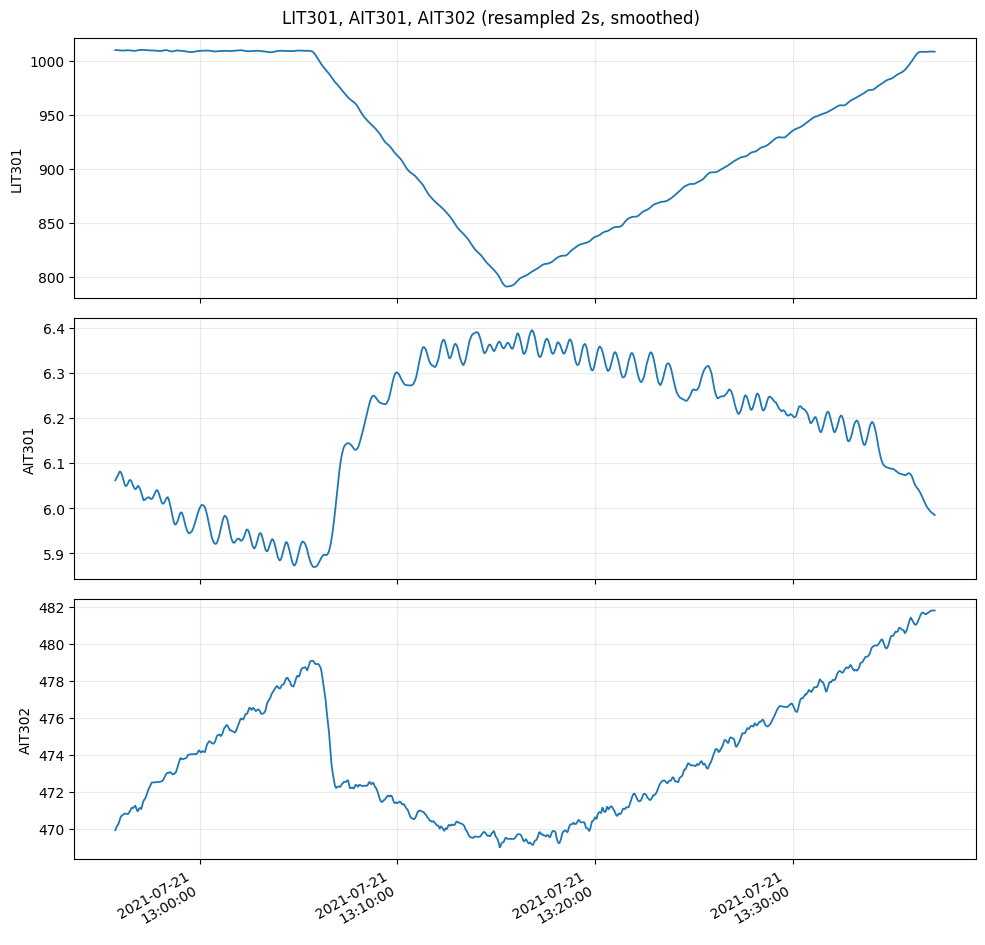

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 1) Choose real columns
# =========================
wanted = ["LIT301", "AIT301", "AIT302"]  # your wish list
available = [c for c in wanted if c in df.columns]
if not available:
    # Fallback if your CSV doesn't have AIT301/302
    fallback = ["LIT301", "AIT201", "AIT203"]
    available = [c for c in fallback if c in df.columns]
if not available:
    raise KeyError("None of the requested columns exist. Check df.columns.")

# =========================
# 2) Ensure datetime index
# =========================
if not isinstance(df.index, pd.DatetimeIndex):
    # Replace 'Timestamp' if your time column has a different name
    if "Timestamp" not in df.columns:
        # Try to guess a timestamp-ish column
        candidates = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
        if not candidates:
            raise KeyError("No datetime index and no 'Timestamp' column found.")
        time_col = candidates[0]
    else:
        time_col = "Timestamp"

    df[time_col] = pd.to_datetime(df[time_col], dayfirst=True, errors="coerce")
    df = df.dropna(subset=[time_col]).set_index(time_col).sort_index()

# =========================
# 3) Prep: clean + resample
# =========================
def prep_series(frame: pd.DataFrame,
                cols,
                freq: str = "2S",
                smooth_window: int = 9,
                clip_q = (0.005, 0.995)) -> pd.DataFrame:
    s = frame[cols].copy()

    # Drop fully empty columns
    s = s.dropna(how="all", axis=1)

    # Force numeric
    for c in s.columns:
        s[c] = pd.to_numeric(s[c], errors="coerce")

    # Uniform time base + interpolate small gaps
    s = s.resample(freq).mean().interpolate(limit_direction="both")

    # Clip extreme spikes so one outlier doesn't wreck the y-scale
    if clip_q is not None:
        lo = s.quantile(clip_q[0])
        hi = s.quantile(clip_q[1])
        s = s.clip(lower=lo, upper=hi, axis=1)

    # Light smoothing for nicer visuals
    if smooth_window and smooth_window > 1:
        s = s.rolling(smooth_window,
                      min_periods=max(1, smooth_window // 2),
                      center=True).mean()

    return s

nice = prep_series(df, available, freq="2S", smooth_window=9)

# =========================
# 4) Stacked plot utility
# =========================
def plot_stack(frame: pd.DataFrame, title="Sensors (clean)"):
    n = frame.shape[1]
    fig, axes = plt.subplots(n, 1, figsize=(10, 6 + 1.2*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, frame.columns):
        ax.plot(frame.index, frame[col], linewidth=1.3)
        ax.set_ylabel(col)
        ax.ticklabel_format(style="plain", axis="y")  # no 1e3 sci-notation
        ax.grid(True, alpha=0.25)

    axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=4, maxticks=8))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=30, ha="right")

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

plot_stack(nice, title=f"{', '.join(nice.columns)} (resampled 2s, smoothed)")

# =========================
# 5) Optional: history/future plot (fixed)
# =========================
def create_time_steps(length: int):
    return list(range(-length, 0))

def show_plot(plot_data, delta: int = 0, title: str = ""):
    """
    plot_data = [history, true_future, pred_future]
      - history: 1D array-like length T
      - true_future: scalar or short array
      - pred_future: scalar or short array
    delta: x of the first future point (usually 0)
    """
    labels  = ['History', 'True Future', 'Model Prediction']
    markers = ['.-',       'rx',          'go']

    history = np.asarray(plot_data[0]).reshape(-1)
    true    = None if len(plot_data) < 2 or plot_data[1] is None else np.asarray(plot_data[1]).reshape(-1)
    pred    = None if len(plot_data) < 3 or plot_data[2] is None else np.asarray(plot_data[2]).reshape(-1)

    ts = create_time_steps(len(history))
    future = int(delta or 0)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(title)

    ax.plot(ts, history, markers[0], label=labels[0])

    if true is not None and true.size:
        ax.plot(np.arange(future, future + true.size), true, markers[1], markersize=8, label=labels[1])
    if pred is not None and pred.size:
        ax.plot(np.arange(future, future + pred.size), pred, markers[2], markersize=8, label=labels[2])

    ax.set_xlabel("Time-Step")
    ax.legend()
    ax.grid(True, alpha=0.25)
    ax.set_xlim([ts[0], max(future + 5, 5)])
    return ax



Multivariate Time Series

In [88]:
# move the index back into a column named 'Timestamp'
df_reset = df.reset_index()                  # index -> column called 'Timestamp'
# confirm name: print(df_reset.columns.tolist())
features = df_reset[['Timestamp', 'LIT301', 'AIT301', 'AIT302']].copy()
features.index = pd.to_datetime(features['Timestamp'], errors='coerce')
features = features.drop(columns='Timestamp')   # optional: keep index only
print(features.head())


                         LIT301    AIT301    AIT302
Timestamp                                          
2021-07-21 12:55:45  1010.27783  6.047186  469.8124
2021-07-21 12:55:46  1010.27783  6.054261  469.8124
2021-07-21 12:55:47  1010.27783  6.059671  469.8124
2021-07-21 12:55:48  1010.27783  6.059671  469.8124
2021-07-21 12:55:49  1010.27783  6.059671  469.8124


In [95]:
import pandas as pd

cols = ['LIT301', 'AIT301', 'AIT302']
# quick sanity prints
\

# if index is not datetime, convert it, otherwise keep it
if not pd.api.types.is_datetime64_any_dtype(df.index):
    time_index = pd.to_datetime(df.index, errors='coerce')
else:
    time_index = df.index

features = df[cols].copy()
features.index = time_index
print(features.head())


                         LIT301    AIT301    AIT302
Timestamp                                          
2021-07-21 12:55:45  1010.27783  6.047186  469.8124
2021-07-21 12:55:46  1010.27783  6.054261  469.8124
2021-07-21 12:55:47  1010.27783  6.059671  469.8124
2021-07-21 12:55:48  1010.27783  6.059671  469.8124
2021-07-21 12:55:49  1010.27783  6.059671  469.8124


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

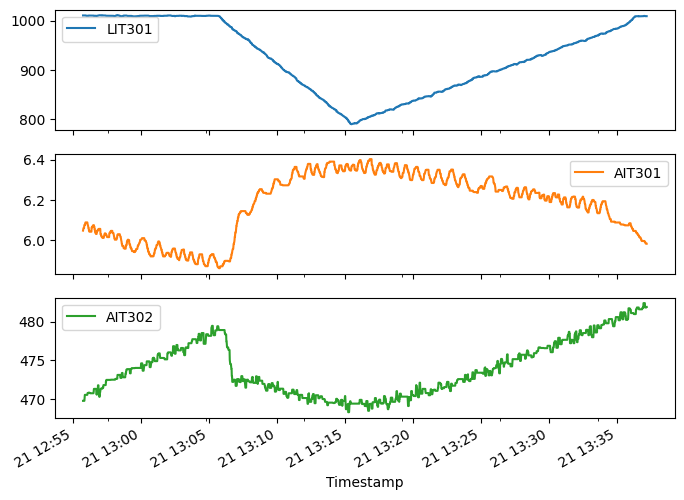

In [96]:
# Draw and show the data over time for 3 attack types
features.plot(subplots=True)

In [97]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [98]:
dataset = (dataset-data_mean)/data_std

In [99]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [100]:
## Plot the training history
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Multistep Model

## Design the model


In [103]:
past_history = 720
future_target = 72
STEP = 1
TRAIN_SPLIT = int(len(dataset) * 0.8)   # <--- important

x_train_multi, y_train_multi = multivariate_data(
    dataset, dataset[:, 1], 0, TRAIN_SPLIT,
    past_history, future_target, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(
    dataset, dataset[:, 1], TRAIN_SPLIT, None,
    past_history, future_target, STEP, single_step=False)


In [104]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target LIT 301 value to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (720, 3)

 Target LIT 301 value to predict : (72,)


In [105]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [106]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

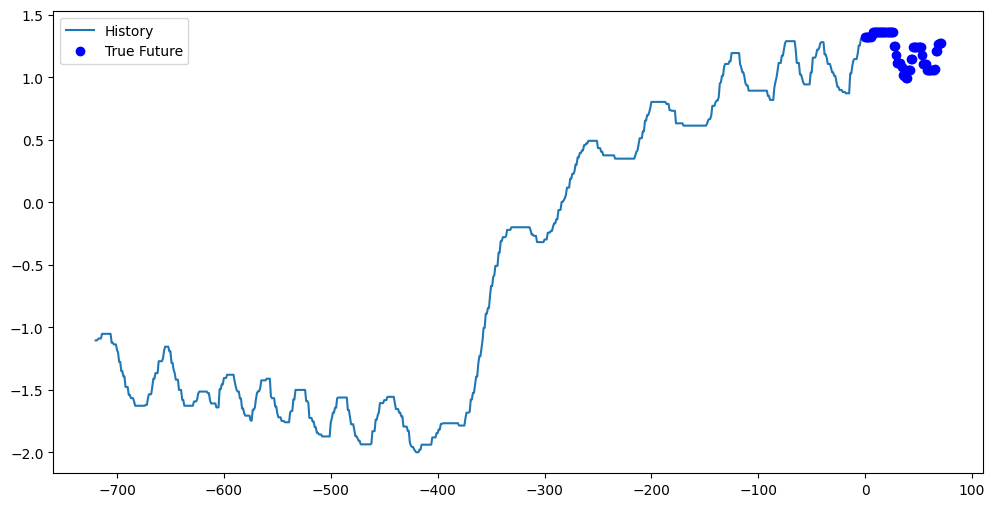

In [107]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [110]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model(timesteps, features, future_target,
                 conv_filters=256, kernel_size=5, pool_size=4, lstm_units=64):
    input_shape = (timesteps, features)   # e.g., x_train_multi.shape[1:]
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(filters=conv_filters,
                      kernel_size=kernel_size,
                      padding='same',
                      activation='tanh')(inputs)
    x = layers.MaxPooling1D(pool_size=pool_size)(x)
    # LSTM expects 3D input (batch, time, features). After pooling it still is 3D.
    x = layers.LSTM(lstm_units)(x)
    # final layer: use linear for regression unless targets are scaled to [-1,1]
    outputs = layers.Dense(units=future_target, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MAE is more informative here
    return model

# usage
timesteps, features = x_train_multi.shape[1], x_train_multi.shape[2]


In [111]:
multi_step_model = create_model(timesteps, features, future_target)
print(multi_step_model.summary())


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 720, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 720, 256)            │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 180, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 72)                  │           4,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,952 (355.28 KB)

 Trainable params: 90,952 (355.28 KB)

 Non-trainable params: 0 (0.00 B)

None


In [114]:
# confirm shapes of the numpy arrays
print("x_train_multi.shape:", x_train_multi.shape)   # expect (N, 720, 3)
print("y_train_multi.shape:", y_train_multi.shape)   # expect (N, future_target) or (N, future_target, something)

# check what train_data_multi actually is and what a batch looks like
print("type(train_data_multi):", type(train_data_multi))
try:
    for element in train_data_multi.take(1):
        print("element type:", type(element))
        if isinstance(element, tuple):
            print("batch x shape, batch y shape:", element[0].shape, element[1].shape)
        else:
            print("single element shape:", element.shape)
except Exception as e:
    print("Error inspecting train_data_multi:", e)


x_train_multi.shape: (1044, 720, 3)
y_train_multi.shape: (1044, 72)
type(train_data_multi): <class 'tensorflow.python.data.ops.repeat_op._RepeatDataset'>
element type: <class 'tuple'>
batch x shape, batch y shape: (256, 720, 3) (256, 72)


In [122]:
# run this to see what's empty/mis-shaped
import numpy as np, pandas as pd
print("x_train_multi:", type(x_train_multi), getattr(x_train_multi,'shape',None), "len()", None if x_train_multi is None else (len(x_train_multi) if hasattr(x_train_multi,'__len__') else None))
print("y_train_multi:", type(y_train_multi), getattr(y_train_multi,'shape',None))
print("x_val_multi :", type(x_val_multi),  getattr(x_val_multi,'shape',None), "len()", None if x_val_multi is None else (len(x_val_multi) if hasattr(x_val_multi,'__len__') else None))
print("y_val_multi :", type(y_val_multi), getattr(y_val_multi,'shape',None))

x_train_multi: <class 'numpy.ndarray'> (1044, 720, 3) len() 1044
y_train_multi: <class 'numpy.ndarray'> (1044, 72)
x_val_multi : <class 'numpy.ndarray'> (0,) len() 0
y_val_multi : <class 'numpy.ndarray'> (0,)


In [ ]:
# assume x_np, y_np are already prepared for training (non-empty)
train_data_multi = tf.data.Dataset.from_tensor_slices((x_np, y_np)).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# do NOT pass validation_data if val is empty
multi_step_history = multi_step_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=max(1, x_np.shape[0] // BATCH_SIZE),
    callbacks=[tensorboard_callback]
)

In [134]:
# fallback: create a tiny val split from the end of x_np
val_size = min( max(1, x_np.shape[0] // 10), 512)  # 10% or up to 512 samples
x_val_np = x_np[-val_size:].astype('float32')
y_val_np = y_np[-val_size:].astype('float32')
x_train_np = x_np[:-val_size]
y_train_np = y_np[:-val_size]

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_np, y_train_np)).shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_np, y_val_np)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

multi_step_history = multi_step_model.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=max(1, x_train_np.shape[0] // BATCH_SIZE),
    validation_data=val_data_multi,
    validation_steps=max(1, x_val_np.shape[0] // BATCH_SIZE),
    callbacks=[tensorboard_callback]
)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - loss: 0.0230 - mae: 0.1303 - val_loss: 0.0159 - val_mae: 0.1057
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0241 - mae: 0.1351 - val_loss: 0.0157 - val_mae: 0.1054
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0227 - mae: 0.1299 - val_loss: 0.0153 - val_mae: 0.1062
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220 - mae: 0.1276 - val_loss: 0.0153 - val_mae: 0.1061
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0223 - mae: 0.1286 - val_loss: 0.0156 - val_mae: 0.1063


In [135]:
TRAIN_SPLIT = int(len(dataset) * 0.8)
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi,   y_val_multi   = multivariate_data(dataset, dataset[:,1], TRAIN_SPLIT, None, past_history, future_target, STEP)

In [136]:
print("train samples:", len(x_train_multi))
print("val samples:  ", len(x_val_multi))


train samples: 1044
val samples:   0


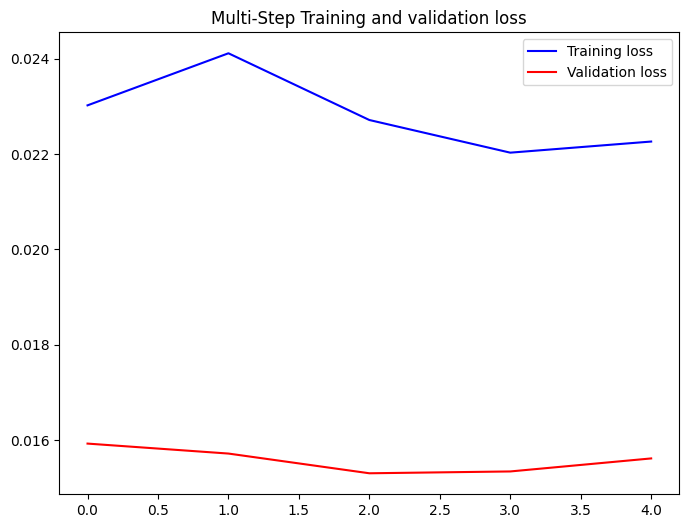

In [138]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


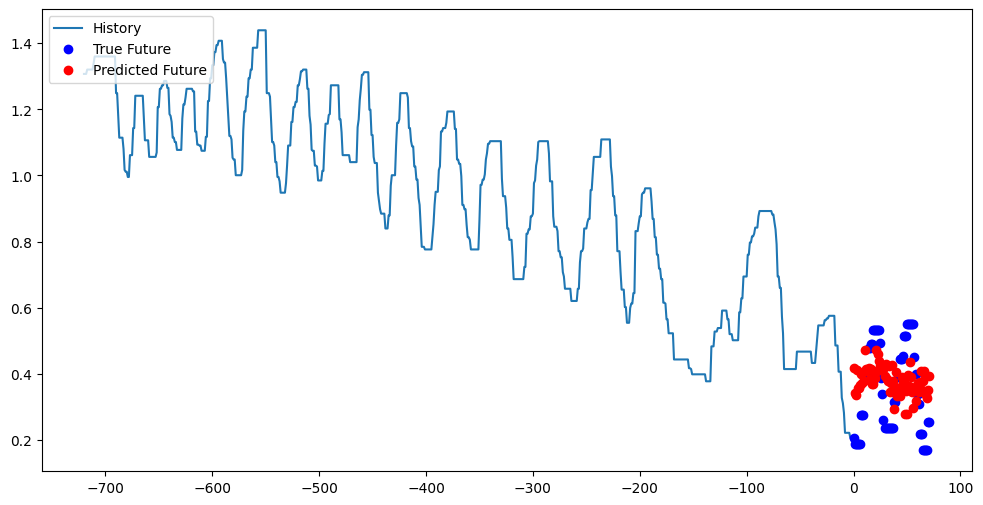

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


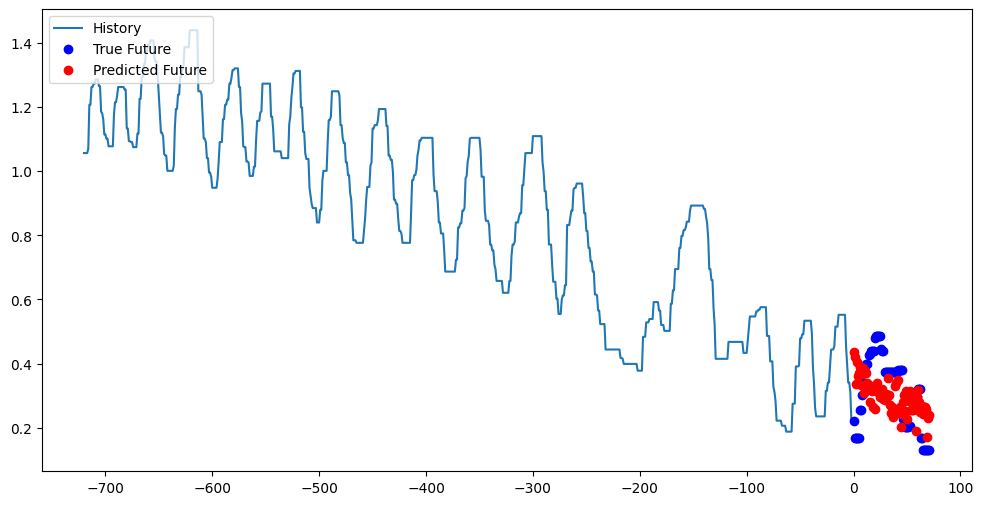

In [139]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [142]:
# Saving the model to reuse
multi_step_model.save('my_model.keras')